In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
df = pd.read_csv("../Dataset/QK-video_subset_5M.csv")
df.head()

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age
0,1,1,1,0,0,0,1,1,1,4
1,1,2,1,0,0,0,1,1,1,4
2,1,3,1,0,0,0,0,1,1,4
3,1,4,0,0,0,0,1,0,1,4
4,2,5,1,0,0,0,1,1,1,4


In [3]:
categorical_cols = ['user_id', 'item_id', 'video_category', 'gender', 'age']
numeric_cols = ['watching_times']
target_col = 'click'

# Encode categorical thành index
feature_index = {}
for feat in categorical_cols:
    df[feat] = df[feat].astype(str)
    unique_vals = df[feat].unique()
    feature_index[feat] = {v: i for i, v in enumerate(unique_vals)}
    df[feat] = df[feat].map(feature_index[feat])

# Scale numeric
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
class DeepFMDataset(Dataset):
    def __init__(self, dataframe, cat_cols, num_cols, target_col):
        self.cat_data = dataframe[cat_cols].values.astype(np.int64)
        self.num_data = dataframe[num_cols].values.astype(np.float32)
        self.labels = dataframe[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.cat_data[idx]),
            torch.tensor(self.num_data[idx]),
            torch.tensor(self.labels[idx])
        )

train_dataset = DeepFMDataset(train_df, categorical_cols, numeric_cols, target_col)
test_dataset = DeepFMDataset(test_df, categorical_cols, numeric_cols, target_col)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)


In [6]:
class DeepFM(nn.Module):
    def __init__(self, cat_dims, num_dim, embed_dim=8, hidden_dims=[128, 64]):
        super(DeepFM, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, embed_dim) for cat_dim in cat_dims
        ])
        self.linear = nn.Linear(len(cat_dims) * embed_dim + num_dim, 1)

        dnn_input_dim = len(cat_dims) * embed_dim + num_dim
        layers = []
        for h in hidden_dims:
            layers.append(nn.Linear(dnn_input_dim, h))
            layers.append(nn.ReLU())
            dnn_input_dim = h
        layers.append(nn.Linear(dnn_input_dim, 1))
        self.dnn = nn.Sequential(*layers)

    def fm_layer(self, x):
        sum_square = torch.sum(x, dim=1) ** 2
        square_sum = torch.sum(x ** 2, dim=1)
        return 0.5 * torch.sum(sum_square - square_sum, dim=1, keepdim=True)

    def forward(self, cat_feats, num_feats):
        embed = [emb(cat_feats[:, i]) for i, emb in enumerate(self.embeddings)]
        embed = torch.stack(embed, dim=1)
        embed_flat = embed.view(embed.size(0), -1)
        x = torch.cat([embed_flat, num_feats], dim=1)

        linear_out = self.linear(x)
        fm_out = self.fm_layer(embed)
        dnn_out = self.dnn(x)

        return torch.sigmoid(linear_out + fm_out + dnn_out)


In [8]:
print(device)

cuda


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cat_dims = [len(feature_index[feat]) for feat in categorical_cols]
model = DeepFM(cat_dims, len(numeric_cols)).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total_loss = 0

    for cat_feats, num_feats, labels in train_loader:
        cat_feats, num_feats, labels = cat_feats.to(device), num_feats.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(cat_feats, num_feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 | Loss: 0.5947
Epoch 2 | Loss: 0.4944
Epoch 3 | Loss: 0.4629
Epoch 4 | Loss: 0.4368
Epoch 5 | Loss: 0.4138
Epoch 6 | Loss: 0.3914
Epoch 7 | Loss: 0.3687
Epoch 8 | Loss: 0.3461
Epoch 9 | Loss: 0.3232
Epoch 10 | Loss: 0.3009


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for cat_feats, num_feats, labels in test_loader:
        cat_feats, num_feats = cat_feats.to(device), num_feats.to(device)
        outputs = model(cat_feats, num_feats).cpu().numpy()
        all_preds.extend((outputs > 0.5).astype(int).flatten())
        all_labels.extend(labels.numpy().flatten())

print("✅ Accuracy:", accuracy_score(all_labels, all_preds))
print("✅ Precision:", precision_score(all_labels, all_preds))
print("✅ Recall:", recall_score(all_labels, all_preds))
print("✅ F1 Score:", f1_score(all_labels, all_preds))


✅ Accuracy: 0.749987
✅ Precision: 0.6976914015830868
✅ Recall: 0.6372136643804112
✅ F1 Score: 0.666082564138865


✅ DeepFM ROC AUC: 0.8224


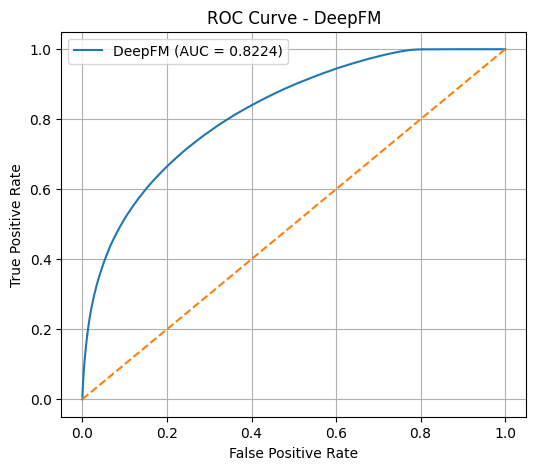

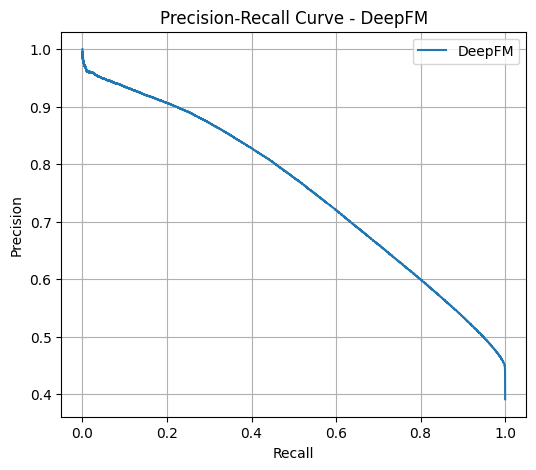

In [13]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for cat_feats, num_feats, labels in test_loader:
        cat_feats, num_feats = cat_feats.to(device), num_feats.to(device)
        outputs = model(cat_feats, num_feats).cpu().numpy()
        all_probs.extend(outputs.flatten())
        all_labels.extend(labels.numpy().flatten())

auc = roc_auc_score(all_labels, all_probs)
print(f"✅ DeepFM ROC AUC: {auc:.4f}")

# Vẽ ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"DeepFM (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DeepFM")
plt.legend()
plt.grid(True)
plt.show()

# Vẽ Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="DeepFM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - DeepFM")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import pickle
import torch

# Lưu mô hình
torch.save(model.state_dict(), "deepfm_model.pth")
print("✅ Đã lưu deepfm_model.pth")

# Lưu feature_index và scaler
with open("feature_index.pkl", "wb") as f:
    pickle.dump(feature_index, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Đã lưu feature_index.pkl và scaler.pkl")


✅ Đã lưu deepfm_model.pth
✅ Đã lưu feature_index.pkl và scaler.pkl
